# Prototypage de Modèles - Avec et Sans Feature Engineering

In [ ]:
# %%
# ===================================================================
# BLOC DE DÉMARRAGE UNIVERSEL (LOCAL + COLAB) - V2
# ===================================================================

import pandas as pd
import numpy as np
import yaml
import sys
import os

# --- 1. Détection de l'environnement ---
IN_COLAB = 'google.colab' in sys.modules

# --- 2. Configuration des chemins ---
if IN_COLAB:
    print("Environnement Google Colab détecté.")
    from google.colab import drive
    drive.mount('/content/drive')
    
    # On suppose que le projet est cloné à la racine de /content/
    project_root = '/content/detectionFraudeTemporaire'
    
    # Cloner le projet si nécessaire
    if not os.path.exists(project_root):
        # --- MODIFIEZ L'URL AVEC CELLE DE VOTRE PROJET ---
        repo_url = "https://github.com/VOTRE_NOM/VOTRE_PROJET.git" 
        !git clone {repo_url} {project_root}
    
    os.chdir(project_root)
    sys.path.append('src')

# --- 3. Chargement de la configuration et des données ---
config_path = 'config/main_config.yaml' if os.path.exists('config/main_config.yaml') else '../config/main_config.yaml'

with open(config_path, 'r') as file:
    config_full = yaml.safe_load(file)

config = config_full['colab'] if IN_COLAB else config_full['local']
data_path = config['data']['raw_data_path']

# En local, le chemin est relatif à la racine du projet, et le notebook est dans un sous-dossier
if not IN_COLAB:
    data_path = f'../{data_path}'
    sys.path.append('../src') # Ajouter src/ au path uniquement en local

df = pd.read_csv(data_path)
print("\n--- Données chargées avec succès ---")
display(df.head())

# --- 4. Importations communes ---
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from features.build_features import preprocess_data
from imblearn.over_sampling import SMOTE

KeyError: 'raw_data_path'

## Version 1 : Sans Feature Engineering

In [5]:
# Préparation des données SANS feature engineering
X_train_v1, y_train_v1, X_test_v1, y_test_v1 = preprocess_data(df, apply_feature_engineering=False)

# Appliquer SMOTE uniquement sur le jeu d'entraînement
print("\nApplication de SMOTE sur la V1...")
smote = SMOTE(random_state=42)
X_train_resampled_v1, y_train_resampled_v1 = smote.fit_resample(X_train_v1, y_train_v1)


Taille du jeu d'entraînement : 227845 lignes
Taille du jeu de test : 56962 lignes

Application de SMOTE sur la V1...


## Version 2 : Avec Feature Engineering

In [6]:
# Préparation des données AVEC feature engineering
X_train_v2, y_train_v2, X_test_v2, y_test_v2 = preprocess_data(df, apply_feature_engineering=True)

# Appliquer SMOTE uniquement sur le jeu d'entraînement
print("\nApplication de SMOTE sur la V2...")
smote = SMOTE(random_state=42)
X_train_resampled_v2, y_train_resampled_v2 = smote.fit_resample(X_train_v2, y_train_v2)

Application du Feature Engineering...
Taille du jeu d'entraînement : 227845 lignes
Taille du jeu de test : 56962 lignes

Application de SMOTE sur la V2...


## Entraînement et Évaluation d'un Modèle de Référence
 
 Nous allons utiliser une Régression Logistique comme premier modèle simple pour comparer les deux approches.


--- Évaluation pour : Version 1 (Sans FE) ---
Rapport de Classification :
              precision    recall  f1-score   support

Légitime (0)       1.00      0.97      0.99     56887
  Fraude (1)       0.04      0.89      0.08        75

    accuracy                           0.97     56962
   macro avg       0.52      0.93      0.53     56962
weighted avg       1.00      0.97      0.99     56962

AUC-ROC: 0.9855
AUC-PR (Precision-Recall): 0.7650


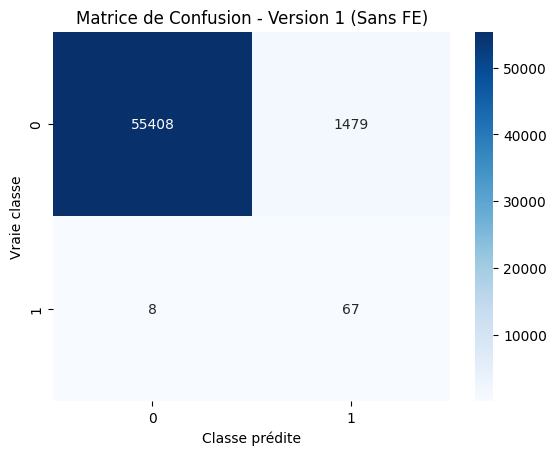


--- Évaluation pour : Version 2 (Avec FE) ---
Rapport de Classification :
              precision    recall  f1-score   support

Légitime (0)       1.00      0.95      0.98     56887
  Fraude (1)       0.03      0.92      0.05        75

    accuracy                           0.95     56962
   macro avg       0.51      0.94      0.51     56962
weighted avg       1.00      0.95      0.98     56962

AUC-ROC: 0.9862
AUC-PR (Precision-Recall): 0.7655


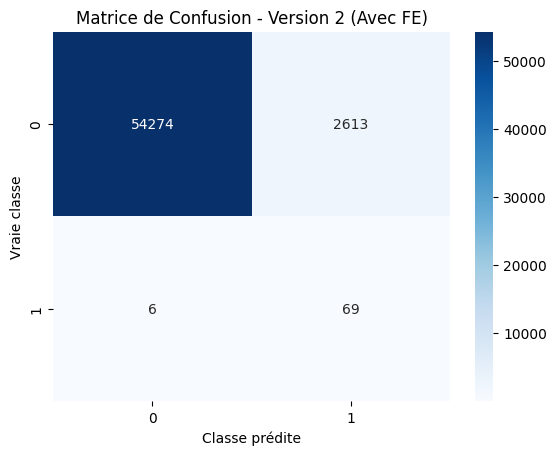

In [7]:
def train_and_evaluate(X_train, y_train, X_test, y_test, version_name):
    """Fonction pour entraîner et évaluer un modèle."""
    print(f"\n--- Évaluation pour : {version_name} ---")
    
    # Entraînement
    model = LogisticRegression(solver='liblinear', random_state=42)
    model.fit(X_train, y_train)
    
    # Prédictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Évaluation
    print("Rapport de Classification :")
    print(classification_report(y_test, y_pred, target_names=['Légitime (0)', 'Fraude (1)']))
    
    auc_roc = roc_auc_score(y_test, y_pred_proba)
    auc_pr = average_precision_score(y_test, y_pred_proba)
    
    print(f"AUC-ROC: {auc_roc:.4f}")
    print(f"AUC-PR (Precision-Recall): {auc_pr:.4f}")
    
    # Matrice de confusion
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matrice de Confusion - {version_name}')
    plt.ylabel('Vraie classe')
    plt.xlabel('Classe prédite')
    plt.show()

# Évaluation de la version 1 (sans feature engineering)
train_and_evaluate(X_train_resampled_v1, y_train_resampled_v1, X_test_v1, y_test_v1, "Version 1 (Sans FE)")

# %%
# Évaluation de la version 2 (avec feature engineering)
train_and_evaluate(X_train_resampled_v2, y_train_resampled_v2, X_test_v2, y_test_v2, "Version 2 (Avec FE)")

## Étape 3 : Entraînement de Modèles Plus Puissants

La Régression Logistique nous a montré que le Feature Engineering est prometteur. Utilisons maintenant des modèles plus complexes (Random Forest, XGBoost) pour voir s'ils peuvent mieux exploiter ces nouvelles features. Nous travaillerons uniquement sur la **Version 2 (Avec FE)**

In [ ]:
# Importation des nouveaux modèles
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# %%
# Mise à jour de notre fonction d'évaluation pour accepter n'importe quel modèle
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    """Fonction générique pour entraîner et évaluer un modèle."""
    print(f"\n--- Évaluation pour : {model_name} ---")
    
    # Entraînement
    model.fit(X_train, y_train)
    
    # Prédictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Évaluation
    print("Rapport de Classification :")
    print(classification_report(y_test, y_pred, target_names=['Légitime (0)', 'Fraude (1)']))
    
    auc_roc = roc_auc_score(y_test, y_pred_proba)
    auc_pr = average_precision_score(y_test, y_pred_proba)
    
    print(f"AUC-ROC: {auc_roc:.4f}")
    print(f"AUC-PR (Precision-Recall): {auc_pr:.4f}")
    
    # Matrice de confusion
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
    plt.title(f'Matrice de Confusion - {model_name}')
    plt.ylabel('Vraie classe')
    plt.xlabel('Classe prédite')
    plt.show()

# %%
# --- Entraînement du Random Forest ---
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
train_and_evaluate_model(rf_model, X_train_resampled_v2, y_train_resampled_v2, X_test_v2, y_test_v2, "Random Forest (avec FE)")